# Seoul Bike Sharing Demand Regression Analysis

**Student name:** Rebecca Chu

## Overview

## Business Problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import statistics as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

from datetime import time
from itertools import combinations

## Data Understanding

### Seoul Bike Sharing System Rentals

The dataset being explored contains the number of public bicycles rented per hour in the Seoul Public Bike (Ttareungyi) rental system and can be found here https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand. It contains 8,760 hours of data, including corresponding weather information and whether the day rented was a holiday.

Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [2]:
sb = pd.read_csv('./data/SeoulBikeData.csv', encoding='latin-1')
sb.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Data Preparation

### 1. Data Cleaning

#### 1.1. Renaming Columns and Converting Datatypes

For readability and ease of writing code, I renamed the columns. I also converted `Date` into a datetime type so that I could extract the month the bikes were rented.

In [3]:
# transforming column names to all lowercase characters 
sb.columns = map(str.lower, sb.columns)

# renaming appropriate columns for readability
sb.rename(
    columns={
        'rented bike count': 'bike_count', 
        'temperature(°c)': 'temp', 
        'humidity(%)': 'humidity', 
        'wind speed (m/s)': 'wind_speed_ms', 
        'visibility (10m)': 'visibility_10m',
        'dew point temperature(°c)': 'dew_point_temp',
        'solar radiation (mj/m2)': 'solar_rad',
        'rainfall(mm)': 'rainfall_mm',
        'snowfall (cm)': 'snowfall_cm',
        'functioning day': 'functioning_day',
    }, 
    inplace=True)

In [4]:
sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             8760 non-null   object 
 1   bike_count       8760 non-null   int64  
 2   hour             8760 non-null   int64  
 3   temp             8760 non-null   float64
 4   humidity         8760 non-null   int64  
 5   wind_speed_ms    8760 non-null   float64
 6   visibility_10m   8760 non-null   int64  
 7   dew_point_temp   8760 non-null   float64
 8   solar_rad        8760 non-null   float64
 9   rainfall_mm      8760 non-null   float64
 10  snowfall_cm      8760 non-null   float64
 11  seasons          8760 non-null   object 
 12  holiday          8760 non-null   object 
 13  functioning_day  8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


In [5]:
# converting date to datetime datatype
sb.date = pd.to_datetime(sb.date, format='%d/%m/%Y')

# descriptive statistics for date Series
sb.date.describe()

count                             8760
mean     2018-05-31 23:59:59.999999744
min                2017-12-01 00:00:00
25%                2018-03-02 00:00:00
50%                2018-06-01 00:00:00
75%                2018-08-31 00:00:00
max                2018-11-30 00:00:00
Name: date, dtype: object

#### 1.2. Dropping Irrelevant Rows

Taking a look at `functioning_day` we can see that the dataframe includes 295 rows where the rental system was not functioning, which corresponds with the number of rows where `bike_count` was 0.

I decided to drop rows where the rental system was not functioning to avoid skewing the model.

In [6]:
sb.functioning_day.value_counts()

functioning_day
Yes    8465
No      295
Name: count, dtype: int64

In [7]:
sb.bike_count.value_counts()

bike_count
0       295
122      19
223      19
262      19
165      18
       ... 
2096      1
2440      1
1600      1
3384      1
595       1
Name: count, Length: 2166, dtype: int64

In [8]:
# creating new dataframe with Functioning Days
sb = sb[sb.functioning_day == 'Yes']

#### 1.3. Creating New Features

In [9]:
# creating a new column for month sold
sb['month'] = sb.date.dt.month

# creating a new column for month sold
sb['day_of_week'] = sb.date.dt.day_name()

I also wanted to explore whether daylight had an impact on the number of bikes rented. Using the Astral package, I created a csv of the dawn and dusk times in Seoul between 01-12-2017 and 30-11-2018 rounded to the nearest hour, which can be found in notebook `dawn-dusk-times.ipynb`. I chose dawn and dusk times over sunrise and sunset so that I could measure from first light to last light. 

In [10]:
sun_info = pd.read_csv('./data/Sun_Info.csv')
sun_info.head()

,Unnamed: 0,dawn,dusk,date
0,0,07:00:00,18:00:00,2017-12-01
1,1,07:00:00,18:00:00,2017-12-02
2,2,07:00:00,18:00:00,2017-12-03
3,3,07:00:00,18:00:00,2017-12-04
4,4,07:00:00,18:00:00,2017-12-05


In [11]:
# dropping the irrelevant column
sun_info.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
sun_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dawn    365 non-null    object
 1   dusk    365 non-null    object
 2   date    365 non-null    object
dtypes: object(3)
memory usage: 8.7+ KB


In [13]:
# converting date column to a datatime datatype so that I can merge sun_info to sb
sun_info.date = pd.to_datetime(sun_info.date)

In [14]:
# merging sun_info to sb
sb = sb.merge(sun_info, on='date', how='left')

So that I can calculate whether `hour` sits within the daylight times between dawn and dusk, I converted `dawn` and `dusk` into floats.

In [15]:
# replacing : with . so that I can convert each value into a float
sb.dawn = sb.dawn.map(lambda x: x.replace(':','.')[:5])
sb.dusk = sb.dusk.map(lambda x: x.replace(':','.')[:5])

# converting dawn and dusk into float datatypes
sb.dawn = sb.dawn.astype(float)
sb.dusk = sb.dusk.astype(float)

In [16]:
daylight = []

# creating a list of whether each hour sits within daylight (1) or not (0)
for i, v in enumerate(sb.bike_count):
    if sb.dawn[i] <= sb.hour[i] < sb.dusk[i]:
        daylight.append(1)
    else:
        daylight.append(0)

sb['daylight'] = daylight

I also decided to change `holiday` into a numerical binary, where 1 = Holiday and 0 = No Holiday. 

In [17]:
# replacing No Holiday with 0
sb.holiday.replace('No Holiday', 0, inplace=True)
# replacing Holiday with 1
sb.holiday.replace('Holiday', 1, inplace=True)

Finally, I dropped irrelevant columns.

In [18]:
# dropping irrelevant columns
sb.drop(['functioning_day', 'dawn', 'dusk'], axis=1, inplace=True)

The final dataset includes the following variables:

* Date
* Rented Bike Count
* Hour
* Temperature (°C)
* Humidity (%)
* Wind Speed (m/s)
* Visibility (10m)
* Dew Point Temperature (°C)
* Solar Radiation (MJ/m2)
* Rainfall (mm)
* Snowfall (cm)
* Season
* Holiday (0 = No Holiday, 1 = Holiday)
* Month
* Day of the Week
* Daylight (0 = No Daylight, 1 = Daylight)

In [19]:
sb.head()

,date,bike_count,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,seasons,holiday,month,day_of_week,daylight
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,12,Friday,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,12,Friday,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,12,Friday,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,12,Friday,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,12,Friday,0


To get a sense of the data I was working with, I grouped ... Below we can see that even within the year, bike rentals tended to increase. There are a few possibilities external to the variables we have that may explain this behaviour; e-bike rentals may have increased in popularity leading, the rental company may have increased the number of its bikes allowing more bikes to be rented. As we can not factor these possibilities into this analysis, I will be focusing on inference rather than prediction.

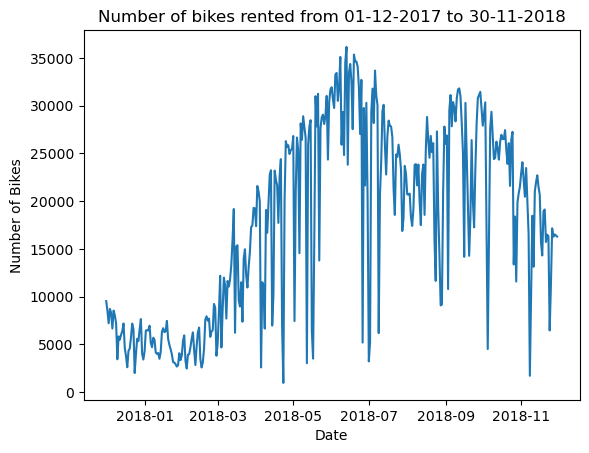

In [20]:
groupedby_date = sb.groupby(['date']).sum().reset_index()

fig, ax = plt.subplots()
ax.plot(groupedby_date['date'], groupedby_date['bike_count'])
ax.set_title('Number of bikes rented from 01-12-2017 to 30-11-2018')

plt.xlabel('Date')
plt.ylabel('Number of Bikes');

#### 1.4. Train Test Split

While the primary goal of this analysis is inference, I decided to split the data into train and test to ensure that the predictors that appeared significant in my model would also be statistically significant for other observations; we want to ensure that these findings are applicable to the future as that is when the advertisements will be aired. I chose to use an 80/20 split.

In [21]:
X = sb.drop('bike_count', axis=1)
y = sb['bike_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [22]:
X_train.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,date,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,holiday,month,daylight
count,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00
mean,.2f,11.49,12.78,58.16,1.74,1425.88,3.95,0.58,0.15,0.08,0.05,6.44,0.55
min,.2f,0.00,-17.50,0.00,0.00,27.00,-30.60,0.00,0.00,0.00,0.00,1.00,0.00
25%,.2f,6.00,3.10,42.00,1.00,920.75,-5.20,0.00,0.00,0.00,0.00,3.00,0.00
50%,.2f,12.00,13.45,57.00,1.50,1669.00,4.70,0.02,0.00,0.00,0.00,6.00,1.00
75%,.2f,17.00,22.70,74.00,2.30,1999.00,15.20,0.95,0.00,0.00,0.00,9.00,1.00
max,.2f,23.00,39.40,98.00,7.40,2000.00,27.20,3.52,35.00,8.80,1.00,12.00,1.00
std,nan,6.89,12.11,20.59,1.04,611.38,13.25,0.88,1.10,0.45,0.22,3.45,0.50


### 2. Exploring the Training Data

#### 2.1. Looking at the Distribution of Variables

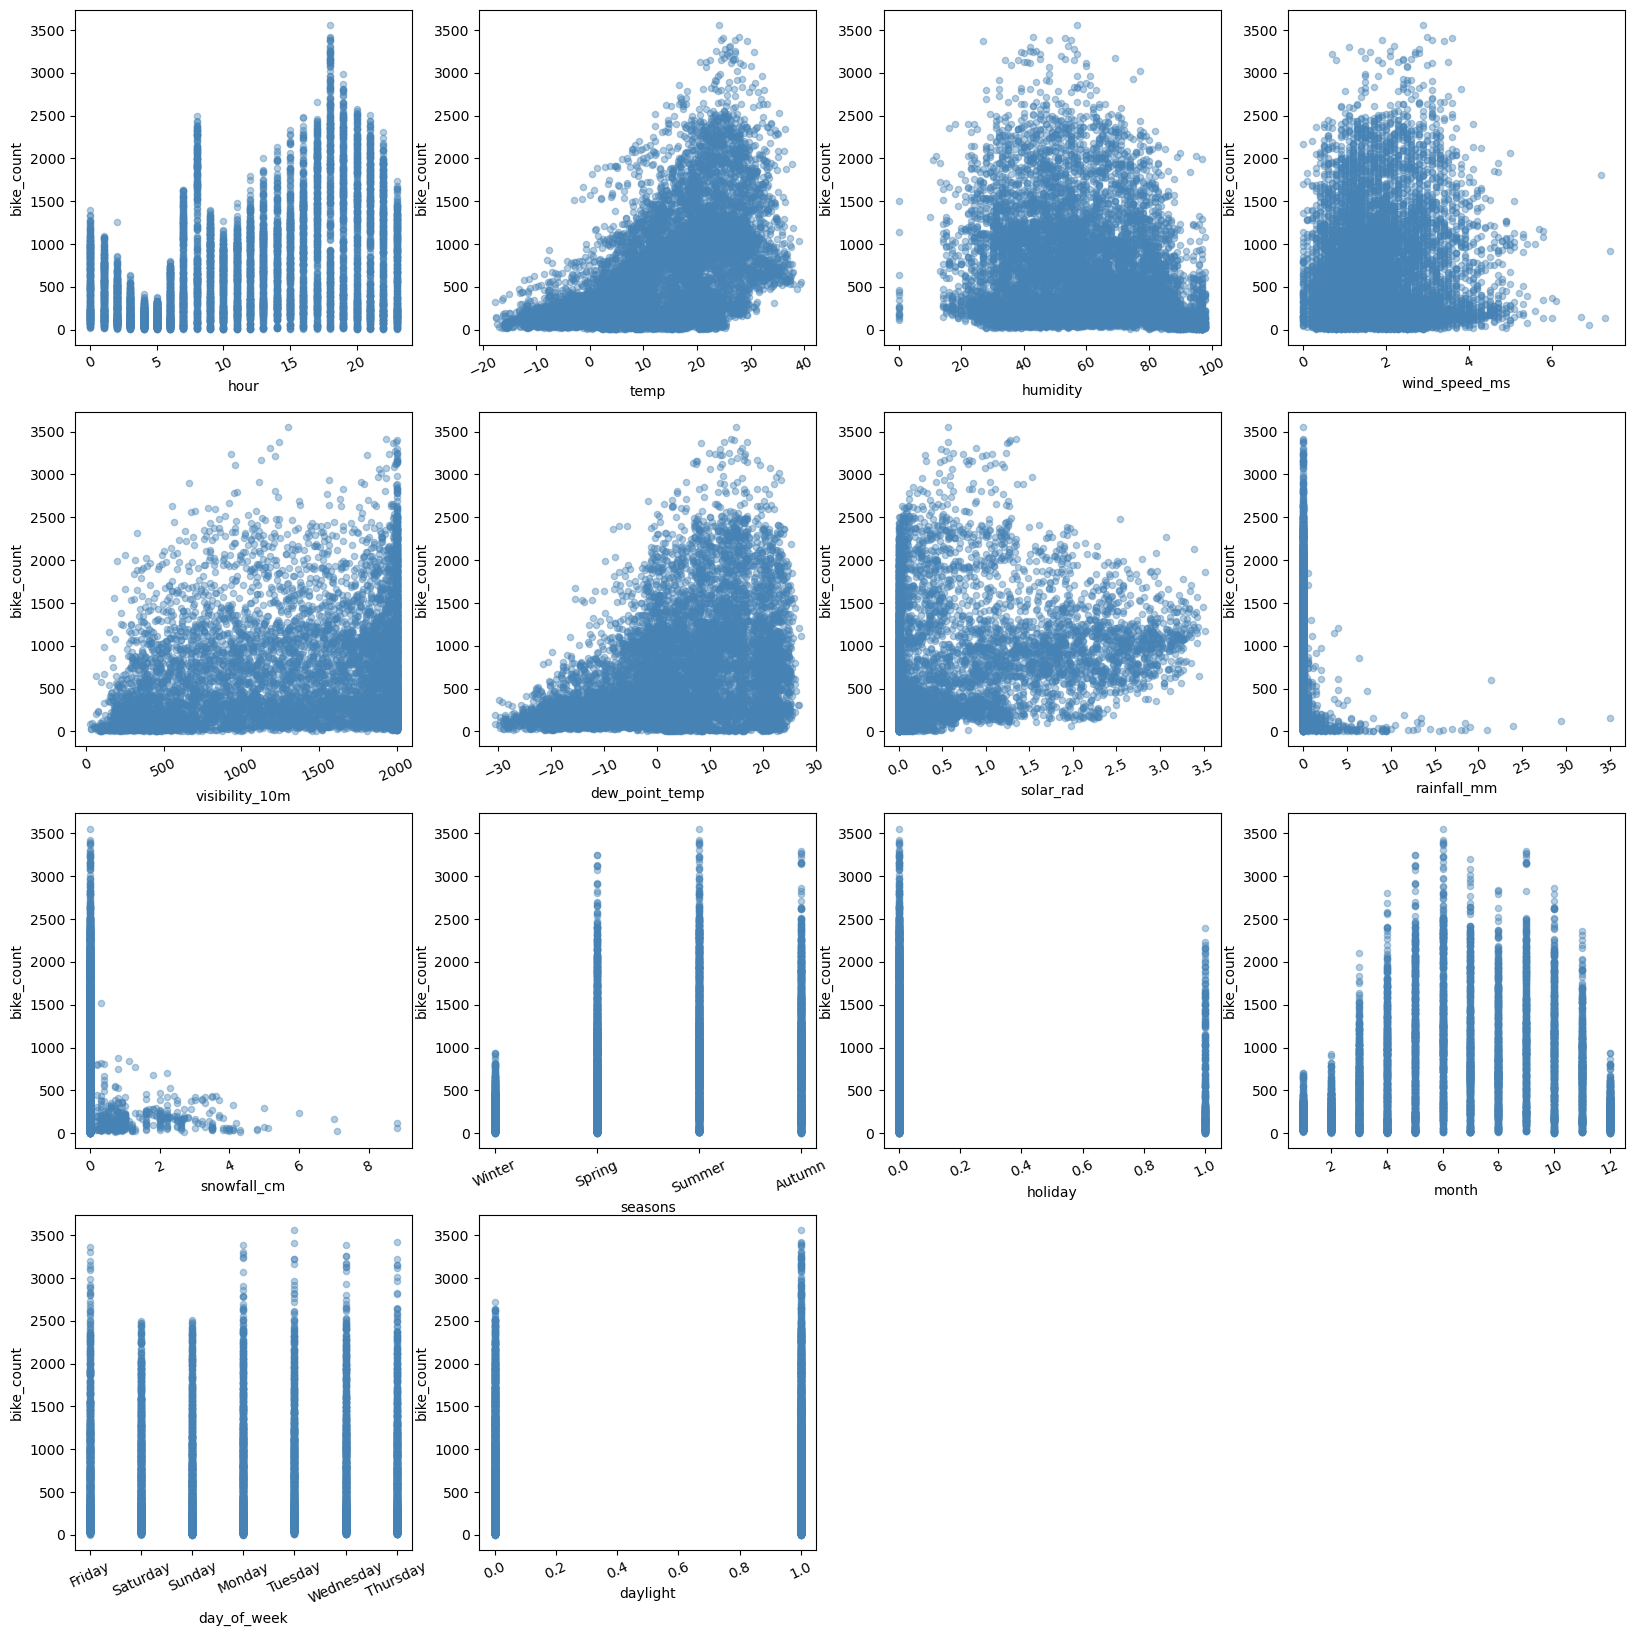

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))

# delete empty subplots
for i in range(2,4):
    fig.delaxes(axes[3,i])

predictors = ['hour', 'temp', 'humidity', 'wind_speed_ms', 'visibility_10m', 'dew_point_temp', 
              'solar_rad', 'rainfall_mm', 'snowfall_cm', 'seasons', 'holiday', 'month', 'day_of_week', 'daylight']

for xcol, ax in zip(predictors, axes.flatten()): 
    sb.plot(kind='scatter', x=xcol, y='bike_count', ax=ax, rot=25, alpha=0.4, color='steelblue');

#### 2.2. Account for Multicollinearity

In [24]:
numerical_data = ['hour', 'temp', 'humidity', 'wind_speed_ms', 'visibility_10m', 'dew_point_temp', 'solar_rad', 
                  'rainfall_mm', 'snowfall_cm', 'holiday', 'month', 'daylight']


X_train[numerical_data].corr()

,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,holiday,month,daylight
hour,1.000000,0.128641,-0.238627,0.292045,0.109612,0.007962,0.150491,0.007564,-0.026597,0.004718,0.003049,0.089974
temp,0.128641,1.000000,0.165073,-0.043967,0.023694,0.913370,0.356843,0.052144,-0.216349,-0.059938,0.214861,0.218752
humidity,-0.238627,0.165073,1.000000,-0.336094,-0.553389,0.540461,-0.463676,0.244102,0.111642,-0.046124,0.138070,-0.220563
wind_speed_ms,0.292045,-0.043967,-0.336094,1.000000,0.182905,-0.181941,0.326663,-0.018746,0.000390,0.034410,-0.160019,0.207580
visibility_10m,0.109612,0.023694,-0.553389,0.182905,1.000000,-0.189854,0.162852,-0.182665,-0.129993,0.029621,0.059907,0.021905
dew_point_temp,0.007962,0.913370,0.540461,-0.181941,-0.189854,1.000000,0.096517,0.129696,-0.147828,-0.069451,0.239759,0.082927
solar_rad,0.150491,0.356843,-0.463676,0.326663,0.162852,0.096517,1.000000,-0.078697,-0.073852,-0.007763,-0.032262,0.592726
rainfall_mm,0.007564,0.052144,0.244102,-0.018746,-0.182665,0.129696,-0.078697,1.000000,0.011176,-0.010901,0.008423,0.024896
snowfall_cm,-0.026597,-0.216349,0.111642,0.000390,-0.129993,-0.147828,-0.073852,0.011176,1.000000,-0.011306,0.061137,-0.005714
holiday,0.004718,-0.059938,-0.046124,0.034410,0.029621,-0.069451,-0.007763,-0.010901,-0.011306,1.000000,0.037509,-0.012419


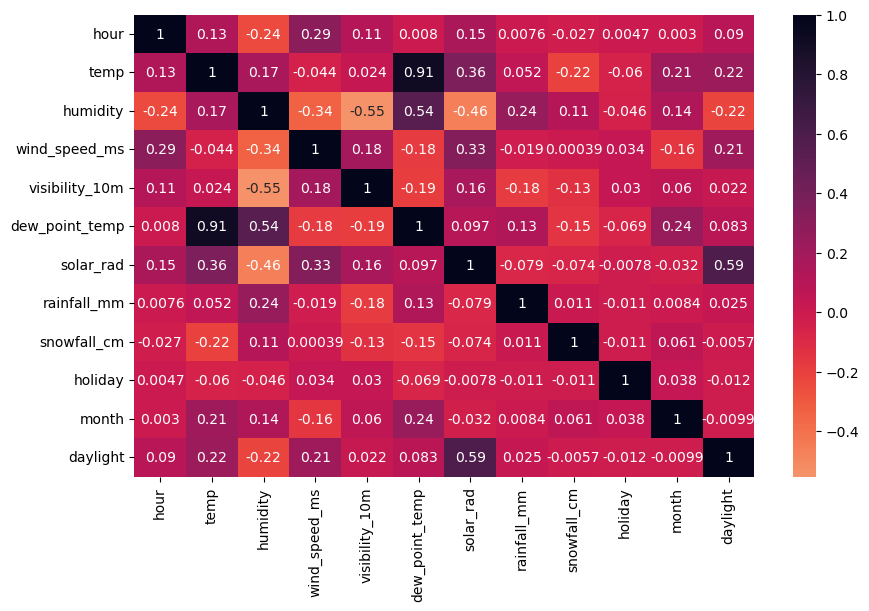

In [25]:
# visualising correlations
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(X_train[numerical_data].corr(), center=0, annot=True, cmap='rocket_r');

In [26]:
# saving absolute value of the correlation matrix as a data frame
df = X_train[numerical_data].corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))
df.drop(columns=['level_1','level_0'], inplace=True)
df.set_index(['pairs'], inplace=True)
df.columns = ['cc']

In [27]:
df[(df.cc >.75) & (df.cc<1)]

,cc
pairs,
"(dew_point_temp, temp)",0.91337
"(temp, dew_point_temp)",0.91337


I decided to drop `dew_point_temp` as we use `temperature` as a reference and may influence people's future decisions whether to rent a bike or not ... 
I also dropped date as I would not be using it for my models.

In [28]:
# dropping dew_point_temp and date
X_train.drop(['dew_point_temp', 'date'], axis=1, inplace=True)

## Data Modeling 

### 1. Preparing for Model 1

#### 1.1. Creating Dummy Variables

In [29]:
def create_dummy(cat, df):
    '''
    Function takes a categorical Series and a dataframe and returns dummy variables using get_dummies(). 
    Note that no columns are dropped.
    '''
    return pd.get_dummies(df[f'{cat}'], prefix=f'{cat}', dtype=float)

For hours, I decided to drop 5am, which appears to see the lowest number of bikes rented per hour.

In [30]:
# creating dummy variables
hour_dummies = create_dummy('hour', X_train)
seasons_dummies = create_dummy('seasons', X_train)
holiday_dummies = create_dummy('holiday', X_train)
month_dummies = create_dummy('month', X_train)
day_dummies = create_dummy('day_of_week', X_train)
daylight_dummies = create_dummy('daylight', X_train)

# removing original columns from dataset
X_train_m1 = X_train.drop(['hour', 'seasons', 'holiday', 'month', 'day_of_week', 'daylight'], 
                                    axis=1)

# concating dummy columns into dataset
X_train_m1 = pd.concat([X_train_m1, hour_dummies, seasons_dummies, holiday_dummies, month_dummies, day_dummies, daylight_dummies], 
                       axis=1)

# removing dropping one column for each categorical
X_train_m1.drop(['hour_5', 'seasons_Winter', 'holiday_1', 'month_1', 'day_of_week_Monday', 'daylight_0', ], axis=1,
                          inplace=True)

X_train_m1.head()

,temp,humidity,wind_speed_ms,visibility_10m,solar_rad,rainfall_mm,snowfall_cm,hour_0,hour_1,hour_2,...,month_10,month_11,month_12,day_of_week_Friday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,daylight_1
2241,8.8,97,1.3,196,0.20,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7149,20.1,54,1.2,2000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5177,26.6,52,2.2,2000,1.02,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3368,14.6,54,0.9,431,0.89,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1459,-1.7,91,1.1,167,0.00,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


                            OLS Regression Results                            
Dep. Variable:             bike_count   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     329.6
Date:                Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:28:46   Log-Likelihood:                -49228.
No. Observations:                6772   AIC:                         9.856e+04
Df Residuals:                    6722   BIC:                         9.890e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -62.23

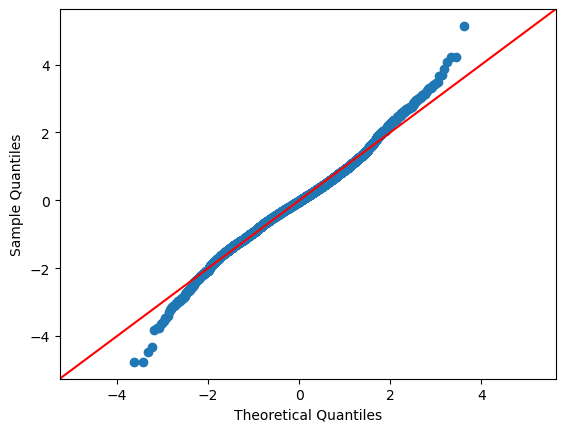

In [31]:
X = X_train_m1
y = y_train

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
print(model.summary())

# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

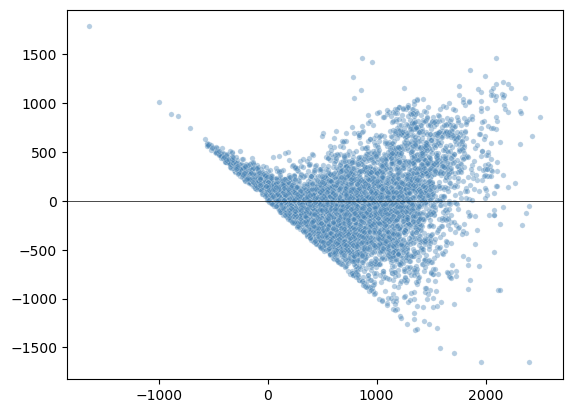

In [32]:
# checking homoscedasticity assumption
pred = model.predict(X_int)
residuals = model.resid

sns.scatterplot(x=pred, y=residuals, s=15, alpha=0.4, color='steelblue')
plt.axhline(y=0, color='black', linewidth=0.5);

In [33]:
name = ['F statistic', 'p-value']
test =  sm.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
list(zip(name, test))

[('F statistic', 0.9708854553851026), ('p-value', 0.8032268554834798)]

### Model 1 Observations

Looking at the model, snowfall appears to have a positive linear relationship with bike rentals, which goes against 

We can see that for rainfall and snowfall, the majority of the distribution lies on 0, with any 

So that these 'outliers' do not skew my model, I decided to treat them as categoricals 

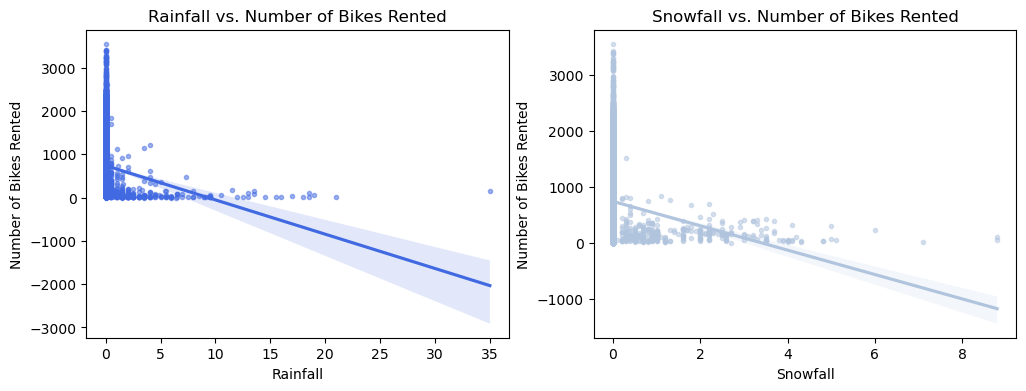

In [34]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.regplot(x=X_train.rainfall_mm, y=y_train, color='royalblue', scatter_kws={'alpha':0.5, 's':9}, ax=axes[0]
           ).set(title='Rainfall vs. Number of Bikes Rented')
sns.regplot(x=X_train.snowfall_cm, y=y_train, color='lightsteelblue', scatter_kws={'alpha':0.5, 's':9}, ax=axes[1]
           ).set(title='Snowfall vs. Number of Bikes Rented')
axes[0].set_xlabel('Rainfall')
axes[1].set_xlabel('Snowfall')
axes[0].set_ylabel('Number of Bikes Rented')
axes[1].set_ylabel('Number of Bikes Rented');

In [35]:
# looking at the correlation between rainfall and snowfall with the no. of bikes using Pearson's correlation coefficient r
corr_rain_bikes = np.corrcoef(X_train.rainfall_mm, y_train)[0,1] 
print(f'Calculated Pearson Correlation (r) between rain and the number of bikes rented is: \
{"{0:.2f}".format(corr_rain_bikes)}')

corr_snow_bikes = np.corrcoef(X_train.snowfall_cm, y_train)[0,1] 
print(f'Calculated Pearson Correlation (r) between snowfall and the number of bikes rented is: \
{"{0:.2f}".format(corr_snow_bikes)}')

Calculated Pearson Correlation (r) between rain and the number of bikes rented is: -0.14
Calculated Pearson Correlation (r) between snowfall and the number of bikes rented is: -0.15


There appears to be almost no correlation between rainfall or snowfall with the number of bike, despite there appearing to be a negative correlation visually.

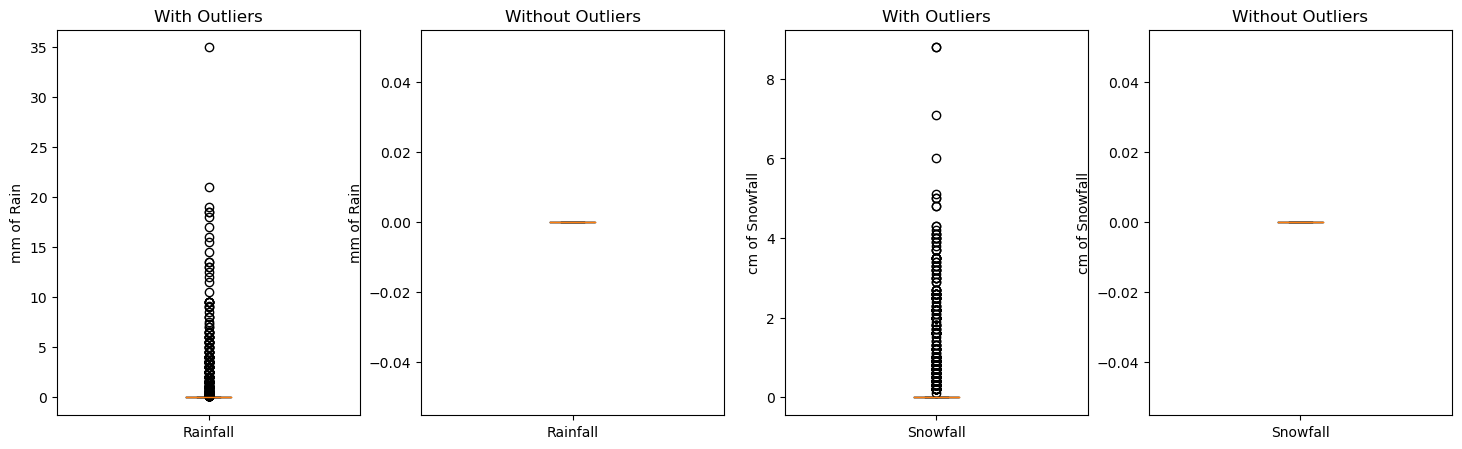

In [36]:
# generating boxplots for rainfall with and without outliers 
fig, axes = plt.subplots(1, 4, figsize=(18,5))

axes[0].boxplot(X_train.rainfall_mm)
axes[1].boxplot(X_train.rainfall_mm, showfliers=False)
axes[2].boxplot(X_train.snowfall_cm)
axes[3].boxplot(X_train.snowfall_cm, showfliers=False)

axes[0].title.set_text('With Outliers')
axes[1].title.set_text('Without Outliers')
axes[0].set_xlabel("Rainfall")
axes[1].set_xlabel("Rainfall")
axes[0].set_ylabel("mm of Rain")
axes[1].set_ylabel("mm of Rain")
axes[0].xaxis.set_tick_params(labelbottom=False)
axes[1].xaxis.set_tick_params(labelbottom=False)

axes[2].title.set_text('With Outliers')
axes[3].title.set_text('Without Outliers')
axes[2].set_xlabel("Snowfall")
axes[3].set_xlabel("Snowfall")
axes[2].set_ylabel("cm of Snowfall")
axes[3].set_ylabel("cm of Snowfall")
axes[2].xaxis.set_tick_params(labelbottom=False)
axes[3].xaxis.set_tick_params(labelbottom=False);

We can see that given that the majority of hours record no rainfall or snowfall, hours with rain or snowfall are acting as outliers and potentially skewing the data. Another point to consider is that the data only measures the amount of rain that fell within the hour, but does not take into consideration the rain's effect on the rest of the day. Logically, rain that falls in the previous hour (depending on the amount that fell) may make roads slicker deterring riders. Further analysis should be done to review the impact of rainfall on the entire day/ the hours following rainfall. 

For now, I have decided to transform rainfall into a categorical variable: 0 rainfall vs. 1 representing any amount of rain. I have also decided to drop snowfall from my second model as it does not seem to have a strong impact on the number of bikes rented. 

### 2. Preparing for Model 2 

In [37]:
X_train.head()

,hour,temp,humidity,wind_speed_ms,visibility_10m,solar_rad,rainfall_mm,snowfall_cm,seasons,holiday,month,day_of_week,daylight
2241,9,8.8,97,1.3,196,0.20,0.2,0.0,Spring,0,3,Sunday,1
7149,21,20.1,54,1.2,2000,0.00,0.0,0.0,Autumn,0,9,Saturday,0
5177,17,26.6,52,2.2,2000,1.02,0.0,0.0,Summer,0,7,Friday,1
3368,8,14.6,54,0.9,431,0.89,0.0,0.0,Spring,0,4,Saturday,1
1459,19,-1.7,91,1.1,167,0.00,0.0,3.0,Winter,0,1,Tuesday,0


In [38]:
X_train.day_of_week.replace(dict.fromkeys(['Monday','Tuesday','Wednesday','Thursday', 'Friday'], 'weekday'), inplace=True)
X_train.day_of_week.replace(dict.fromkeys(['Saturday','Sunday'], 'weekend'), inplace=True)

In [39]:
X_train.day_of_week.value_counts()

day_of_week
weekday    4853
weekend    1919
Name: count, dtype: int64

In [40]:
# transforming rainfall into a categorical variable
X_train.rainfall_mm = np.where(X_train.rainfall_mm > 0, 1, X_train.rainfall_mm)

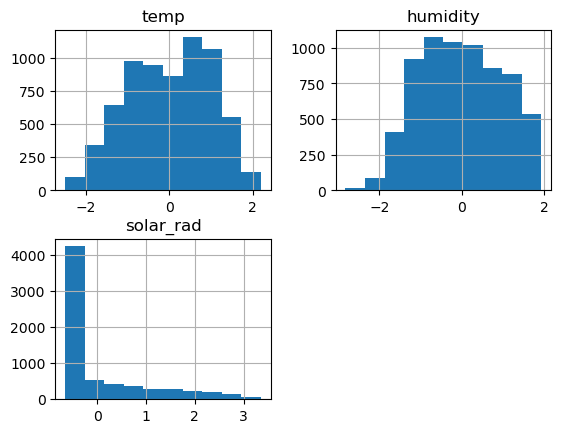

In [41]:
def normalize(feature):
    return (feature - feature.mean())/ feature.std()

cont = ['temp', 'humidity', 'solar_rad']

X_train_m2 = X_train[cont].apply(normalize)

X_train_m2.hist();

In [42]:
# creating dummy variables
hour_dummies = create_dummy('hour', X_train)
rain_dummies = create_dummy('rainfall_mm', X_train)
holiday_dummies = create_dummy('holiday', X_train)
month_dummies = create_dummy('month', X_train)
day_dummies = create_dummy('day_of_week', X_train)
daylight_dummies = create_dummy('daylight', X_train)

# concating dummy columns into dataset
X_train_m2 = pd.concat([X_train_m2, hour_dummies, rain_dummies, holiday_dummies, month_dummies, 
                        day_dummies, daylight_dummies], axis=1)

# removing dropping one column for each categorical
X_train_m2.drop(['hour_5', 'rainfall_mm_0.0', 'holiday_1', 'month_1', 'day_of_week_weekday', 
                 'daylight_0'], axis=1, inplace=True)

X_train_m2.head()

,temp,humidity,solar_rad,hour_0,hour_1,hour_2,hour_3,hour_4,hour_6,hour_7,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_weekend,daylight_1
2241,-0.328755,1.886252,-0.434182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7149,0.604411,-0.202033,-0.662616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5177,1.141188,-0.299162,0.502398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3368,0.150215,-0.202033,0.353916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1459,-1.195855,1.594863,-0.662616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


                            OLS Regression Results                            
Dep. Variable:             bike_count   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     427.1
Date:                Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:28:47   Log-Likelihood:                -49035.
No. Observations:                6772   AIC:                         9.815e+04
Df Residuals:                    6730   BIC:                         9.844e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -39.3556    

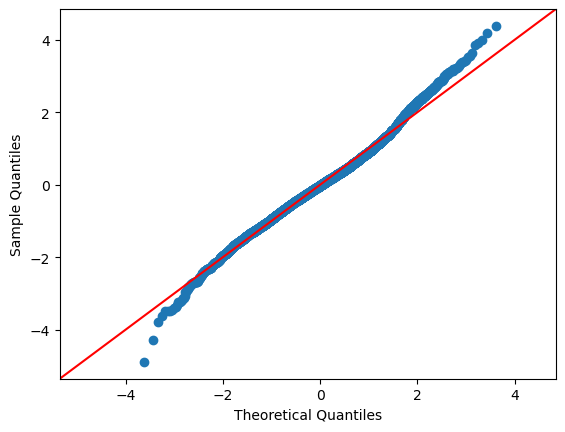

In [43]:
X = X_train_m2
y = y_train

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
print(model.summary())

# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

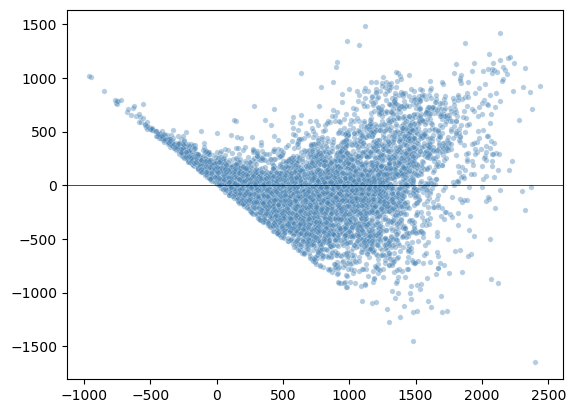

In [44]:
# checking homoscedasticity assumption
pred = model.predict(X_int)
residuals = model.resid

sns.scatterplot(x=pred, y=residuals, s=15, alpha=0.4, color='steelblue')
plt.axhline(y=0, color='black', linewidth=0.5);

In [45]:
name = ['F statistic', 'p-value']
test =  sm.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
list(zip(name, test))

[('F statistic', 0.9530149017828059), ('p-value', 0.9179314615859071)]

In [46]:
linreg = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(linreg, X, y, scoring="r2", cv=crossvalidation))

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data["interaction"] = data[a] * data[b]
    score = np.mean(
        cross_val_score(linreg, data, y, scoring="r2", cv=crossvalidation)
    )
    if score > baseline:
        interactions.append((a, b, round(score, 3)))

    if i % 50 == 0:
        print(i)

print(
    "Top 5 interactions: %s"
    % sorted(interactions, key=lambda inter: inter[2], reverse=True)[:5]
)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
Top 5 interactions: [('hour_8', 'day_of_week_weekend', 0.732), ('temp', 'hour_18', 0.729), ('temp', 'hour_19', 0.729), ('solar_rad', 'hour_19', 0.728), ('temp', 'hour_20', 0.727)]


In [47]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
final_m2 = X.copy()

final_m2['hour_8*day_of_week_weekend'] = (final_m2['hour_8'] * final_m2['day_of_week_weekend'])

final_model_2 = np.mean(cross_val_score(linreg, final_m2, y, scoring="r2", cv=crossvalidation))

print(f'Baseline r2: {baseline}')
print(f'Final Model r2: {final_model_2}')

Baseline r2: 0.7183393256853814
Final Model r2: 0.7316050004998138


In [48]:
final_m2['temp*hour_18'] = (final_m2['temp'] * final_m2['hour_18'])

final_model_2 = np.mean(cross_val_score(linreg, final_m2, y, scoring="r2", cv=crossvalidation))

print(f'Baseline r2: {baseline}')
print(f'Final Model r2: {final_model_2}')

Baseline r2: 0.7183393256853814
Final Model r2: 0.7426701467918635


In [49]:
final_m2['temp*hour_19'] = (final_m2['temp'] * final_m2['hour_19'])

final_model_2 = np.mean(cross_val_score(linreg, final_m2, y, scoring="r2", cv=crossvalidation))

print(f'Baseline r2: {baseline}')
print(f'Final Model r2: {final_model_2}')

Baseline r2: 0.7183393256853814
Final Model r2: 0.7572989101632162


In [50]:
X_int = sm.add_constant(final_m2)
model = sm.OLS(y, X_int).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bike_count   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     488.1
Date:                Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:29:53   Log-Likelihood:                -48521.
No. Observations:                6772   AIC:                         9.713e+04
Df Residuals:                    6727   BIC:                         9.744e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         18.1084     34.932      0.518      0.604     -50.370      86.587
temp                         224.2587     12.189     18.399      0.000     200.365     248.153
humidity                    -102.4317      5.548    -18.464      0.000    -113.307     -91.557
solar_rad                     34.7943      8.153      4.267      0.000      18.811      50.777
hour_0                       291.8828     27.754     10.517      0.000     237.475     346.290
hour_1                       167.4756     27.748      6.036      0.000     113.081     221.870
hour_2                        67.8292     27.836      2.437      0.015      13.262     122.397
hour_3                         0.5564     27.799      0.020      0.984     -53.939      55.051
hour_4                       -92.4270     27.799     -3.325      0.001    -146.922     -37.932
hour_6                       251.7994     27.410      9.187      0.000     198.068     305.531
hour_7                       607.7511     30.473     19.944      0.000     548.014     667.488
hour_8                      1243.6054     32.905     37.794      0.000    1179.102    1308.109
hour_9                       569.9115     31.431     18.132      0.000     508.297     631.526
hour_10                      350.9146     32.381     10.837      0.000     287.437     414.392
hour_11                      366.3159     33.558     10.916      0.000     300.532     432.099
hour_12                      427.4576     34.630     12.344      0.000     359.572     495.343
hour_13                      429.3071     34.734     12.360      0.000     361.218     497.396
hour_14                      448.6525     34.478     13.013      0.000     381.065     516.239
hour_15                      523.7057     33.821     15.484      0.000     457.405     590.006
hour_16                      628.8015     32.829     19.154      0.000     564.446     693.157
hour_17                      910.3460     32.162     28.305      0.000     847.298     973.394
hour_18                     1204.9458     28.381     42.456      0.000    1149.310    1260.582
hour_19                      893.1641     27.348     32.659      0.000     839.553     946.776
hour_20                      736.2359     28.752     25.607      0.000     679.873     792.598
hour_21                      725.5856     28.047     25.870      0.000     670.605     780.567
hour_22                      636.6795     28.033     22.712      0.000     581.726     691.633
hour_23                      398.9148     27.739     14.381      0.000     344.537     453.293
rainfall_mm_1.0             -543.6619     18.193    -29.884      0.000    -579.325    -507.999
holiday_0                    147.0658     18.162      8.098      0.000     111.463     182.668
month_2                      -36.1772     1

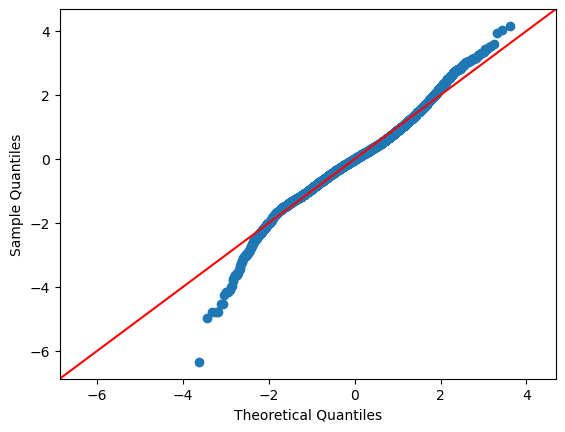

In [51]:
# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

In [52]:
name = ['Jarque-Bera', 'Prob', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 750.6873000542828),
 ('Prob', 9.779664941329661e-164),
 ('Skew', -0.014527779492115313),
 ('Kurtosis', 4.630826512274357)]

### Final Model

As the interactions seemed to violate the normality assumption, I decided to only include the strongest interaction as the purpose of this regression analysis is inference not prediction.

In [53]:
cont = ['temp', 'humidity', 'solar_rad']

X_train_m3 = X_train[cont].apply(normalize)

# creating dummy variables
hour_dummies = create_dummy('hour', X_train)
rain_dummies = create_dummy('rainfall_mm', X_train)
holiday_dummies = create_dummy('holiday', X_train)
month_dummies = create_dummy('month', X_train)
day_dummies = create_dummy('day_of_week', X_train)
daylight_dummies = create_dummy('daylight', X_train)

# concating dummy columns into dataset
X_train_m3 = pd.concat([X_train_m3, hour_dummies, rain_dummies, holiday_dummies, month_dummies, 
                        day_dummies, daylight_dummies], axis=1)

# removing dropping one column for each categorical
X_train_m3.drop(['hour_5', 'rainfall_mm_0.0', 'holiday_1', 'month_1', 'day_of_week_weekday', 
                 'daylight_0'], axis=1, inplace=True)


X_train_m3['hour_8*day_of_week_weekend'] = (X_train_m3['hour_8'] * X_train_m3['day_of_week_weekend'])

In [54]:
X = X_train_m3
y = y_train 

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bike_count   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     446.1
Date:                Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:29:53   Log-Likelihood:                -48868.
No. Observations:                6772   AIC:                         9.782e+04
Df Residuals:                    6729   BIC:                         9.811e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -44.4363     36.676     -1.212      0.226    -116.332      27.460
temp                         264.4919     12.731     20.776      0.000     239.536     289.448
humidity                    -106.8469      5.835    -18.311      0.000    -118.285     -95.408
solar_rad                     37.4884      8.572      4.373      0.000      20.684      54.293
hour_0                       390.0442     28.955     13.471      0.000     333.284     446.804
hour_1                       265.9508     28.946      9.188      0.000     209.208     322.694
hour_2                       168.5759     29.028      5.807      0.000     111.672     225.480
hour_3                       102.1746     28.984      3.525      0.000      45.357     158.992
hour_4                        10.1475     28.978      0.350      0.726     -46.659      66.954
hour_6                       156.1236     28.601      5.459      0.000     100.056     212.191
hour_7                       419.3023     31.210     13.435      0.000     358.121     480.484
hour_8                      1051.7571     33.806     31.112      0.000     985.488    1118.027
hour_9                       370.3955     32.145     11.523      0.000     307.381     433.411
hour_10                      145.1350     33.116      4.383      0.000      80.218     210.052
hour_11                      154.0098     34.328      4.486      0.000      86.717     221.303
hour_12                      209.5243     35.435      5.913      0.000     140.061     278.988
hour_13                      207.6346     35.512      5.847      0.000     138.020     277.249
hour_14                      225.3194     35.219      6.398      0.000     156.280     294.359
hour_15                      299.5992     34.499      8.684      0.000     231.970     367.229
hour_16                      407.6745     33.451     12.187      0.000     342.100     473.249
hour_17                      692.2586     32.756     21.134      0.000     628.046     756.471
hour_18                     1179.3032     29.677     39.738      0.000    1121.127    1237.479
hour_19                      910.4515     28.719     31.703      0.000     854.154     966.749
hour_20                      824.9675     30.058     27.446      0.000     766.044     883.891
hour_21                      817.1397     29.298     27.891      0.000     759.706     874.573
hour_22                      730.9405     29.270     24.972      0.000     673.562     788.319
hour_23                      494.1373     28.954     17.066      0.000     437.379     550.896
rainfall_mm_1.0             -537.4652     19.140    -28.080      0.000    -574.986    -499.944
holiday_0                    150.6873     19.112      7.884      0.000     113.221     188.154
month_2                      -43.2887     2

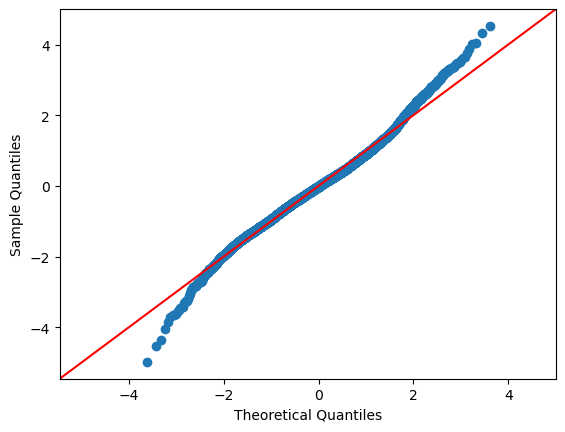

In [55]:
# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

In [56]:
name = ['Jarque-Bera', 'Prob', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 370.32912175027764),
 ('Prob', 3.8375404645999526e-81),
 ('Skew', 0.16986232268924067),
 ('Kurtosis', 4.094091094350158)]

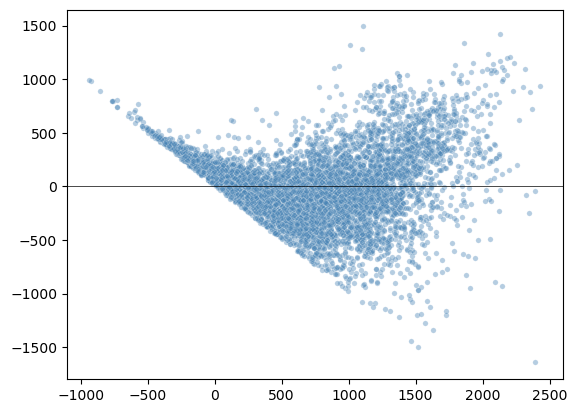

In [57]:
# checking homoscedasticity assumption
pred = model.predict(X_int)
residuals = model.resid

sns.scatterplot(x=pred, y=residuals, s=15, alpha=0.4, color='steelblue')
plt.axhline(y=0, color='black', linewidth=0.5);

In [58]:
name = ['F statistic', 'p-value']
test =  sm.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
list(zip(name, test))

[('F statistic', 0.9625554507434023), ('p-value', 0.8650230337771144)]

## Evaluation
### Model Validation

In [59]:
linreg.fit(X, y)

LinearRegression()

In [60]:
X_test.day_of_week.replace(dict.fromkeys(['Monday','Tuesday','Wednesday','Thursday', 'Friday'], 'weekday'), inplace=True)
X_test.day_of_week.replace(dict.fromkeys(['Saturday','Sunday'], 'weekend'), inplace=True)

# transforming rainfall into a categorical variable
X_test.rainfall_mm = np.where(X_test.rainfall_mm > 0, 1, X_test.rainfall_mm)

X_test.head()

,date,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,seasons,holiday,month,day_of_week,daylight
2921,2018-04-01,17,18.0,72,1.8,559,12.8,0.47,0.0,0.0,Spring,0,4,weekend,1
3252,2018-04-16,12,15.5,33,2.5,1893,-0.7,3.10,0.0,0.0,Spring,0,4,weekday,1
3638,2018-05-02,14,17.5,94,0.3,436,16.5,0.35,0.0,0.0,Spring,0,5,weekday,1
5355,2018-07-14,3,25.2,83,1.1,1835,22.0,0.00,0.0,0.0,Summer,0,7,weekend,0
7517,2018-10-19,12,17.4,33,1.1,2000,0.9,2.39,0.0,0.0,Autumn,0,10,weekday,1


In [61]:
cont = ['temp', 'humidity', 'solar_rad']

X_test_processed = X_test[cont].apply(normalize)

# creating dummy variables
hour_dummies = create_dummy('hour', X_test)
rain_dummies = create_dummy('rainfall_mm', X_test)
holiday_dummies = create_dummy('holiday', X_test)
month_dummies = create_dummy('month', X_test)
day_dummies = create_dummy('day_of_week', X_test)
daylight_dummies = create_dummy('daylight', X_test)

# concating dummy columns into dataset
X_test_processed = pd.concat([X_test_processed, hour_dummies, rain_dummies, holiday_dummies, month_dummies, 
                        day_dummies, daylight_dummies], axis=1)

# removing dropping one column for each categorical
X_test_processed.drop(['hour_5', 'rainfall_mm_0.0', 'holiday_1', 'month_1', 'day_of_week_weekday', 
                 'daylight_0'], axis=1, inplace=True)


X_test_processed['hour_8*day_of_week_weekend'] = (X_test_processed['hour_8'] * X_test_processed['day_of_week_weekend'])

In [62]:
linreg.score(X, y)

0.7357580554763024

In [63]:
X_test = X_test_processed
y_test = y_test

linreg.score(X_test, y_test)

0.7227096442961216

In [64]:
y_hat_train = linreg.predict(X)
y_hat_test = linreg.predict(X_test_processed)

In [65]:
train_mse = mean_squared_error(y, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 108487.02635033424
Test Mean Squared Error: 116622.68169831471


In [66]:
model.params

const                          -44.436307
temp                           264.491900
humidity                      -106.846881
solar_rad                       37.488423
hour_0                         390.044213
hour_1                         265.950800
hour_2                         168.575942
hour_3                         102.174556
hour_4                          10.147549
hour_6                         156.123594
hour_7                         419.302269
hour_8                        1051.757121
hour_9                         370.395545
hour_10                        145.135017
hour_11                        154.009849
hour_12                        209.524291
hour_13                        207.634552
hour_14                        225.319395
hour_15                        299.599182
hour_16                        407.674520
hour_17                        692.258558
hour_18                       1179.303151
hour_19                        910.451510
hour_20                        824